# HO SOLO UN TX E UN RX

*TX1-->RX1 canale 6 |
 TX2-->RX2 canale 11*

In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
from hampel import hampel
from scipy.signal import savgol_filter

In [2]:
assenza = pd.read_csv('Vecchi_dati/assenza2conorario.csv')

una_movimento=pd.read_csv('Vecchi_dati/unapersonachesimuoveconorario.csv')

una_ferma=pd.read_csv('Vecchi_dati/unapersonafermaconorario.csv')

due_movimento=pd.read_csv('Vecchi_dati/duepersonechesimuovonoconorario.csv')

due_ferme=pd.read_csv('Vecchi_dati/duepersonefermeconorario.csv')

una_entra_esce=pd.read_csv('Vecchi_dati/unapersonaentraesceconorario.csv')

In [3]:
def convert_to_complex(csi_data):
    # Assumiamo che csi_data sia una lista con alternanza di I e Q
    complex_data = []
    for i in range(0, len(csi_data), 2):  # passo di 2 per prendere I e Q
        real = csi_data[i]
        imag = csi_data[i+1] if i+1 < len(csi_data) else 0
        complex_data.append(complex(real, imag))
    return complex_data

In [4]:
# convertiamo le stringhe in liste di numeri 

assenza['data'] = assenza['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

una_movimento['data'] = una_movimento['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
una_ferma['data'] = una_ferma['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    
due_movimento['data'] = due_movimento['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
due_ferme['data'] = due_ferme['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

una_entra_esce['data'] = una_entra_esce['data'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)



In [5]:
#trasformo i dati in numeri complessi
assenza['data_complex'] = assenza['data'].apply(convert_to_complex)
una_movimento['data_complex'] = una_movimento['data'].apply(convert_to_complex)

una_ferma['data_complex'] = una_ferma['data'].apply(convert_to_complex)
due_movimento['data_complex'] = due_movimento['data'].apply(convert_to_complex)

due_ferme['data_complex'] = due_ferme['data'].apply(convert_to_complex)
una_entra_esce['data_complex'] = una_entra_esce['data'].apply(convert_to_complex)



In [6]:
# Seleziona solo le colonne di interesse, in questo caso tieniamo i csi e i timestamp 
columns_to_keep = ['data_complex', 'local_timestamp']

# Rimuovi tutte le altre colonne
assenza = assenza[columns_to_keep]
una_movimento = una_movimento[columns_to_keep]

una_ferma = una_ferma[columns_to_keep]
due_movimento = due_movimento[columns_to_keep]

due_ferme = due_ferme[columns_to_keep]
una_entra_esce = una_entra_esce[columns_to_keep]



In [7]:
# Separiamo i numeri complessi in colonne direttamente nel DataFrame originale
assenza[[f'{i}' for i in range(len(assenza['data_complex'].iloc[0]))]] = pd.DataFrame(assenza['data_complex'].tolist(), index=assenza.index)
una_movimento[[f'{i}' for i in range(len(una_movimento['data_complex'].iloc[0]))]] = pd.DataFrame(una_movimento['data_complex'].tolist(), index=una_movimento.index)

una_ferma[[f'{i}' for i in range(len(una_ferma['data_complex'].iloc[0]))]] = pd.DataFrame(una_ferma['data_complex'].tolist(), index=una_ferma.index)
due_movimento[[f'{i}' for i in range(len(due_movimento['data_complex'].iloc[0]))]] = pd.DataFrame(due_movimento['data_complex'].tolist(), index=due_movimento.index)

due_ferme[[f'{i}' for i in range(len(due_ferme['data_complex'].iloc[0]))]] = pd.DataFrame(due_ferme['data_complex'].tolist(), index=due_ferme.index)
una_entra_esce[[f'{i}' for i in range(len(una_entra_esce['data_complex'].iloc[0]))]] = pd.DataFrame(una_entra_esce['data_complex'].tolist(), index=una_entra_esce.index)


C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\2286356482.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assenza[[f'{i}' for i in range(len(assenza['data_complex'].iloc[0]))]] = pd.DataFrame(assenza['data_complex'].tolist(), index=assenza.index)
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\2286356482.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  assenza[[f'{i}' for i in range(len(assenza['data_complex'].iloc[0]))]] = pd.DataFrame(assenza['data_complex'].tolist(), index=assenza.index)
C:\Users\mariu\AppData\Loc

In [8]:
# Rimuoviamo la colonna originale dei numeri complessi che ora sono state separate in colonne individuali

assenza= assenza.drop(columns=['data_complex'])
una_movimento= una_movimento.drop(columns=['data_complex'])

una_ferma= una_ferma.drop(columns=['data_complex'])
due_movimento= due_movimento.drop(columns=['data_complex'])

due_ferme= due_ferme.drop(columns=['data_complex'])
una_entra_esce= una_entra_esce.drop(columns=['data_complex'])


In [9]:
def split_csi_dataset(df: pd.DataFrame):
    """
    Divide un DataFrame CSI in due dataset separati:
      - LLTF (0..63)
      - HT-LTF (-64..-1, 0..63)
    
    Restituisce:
      lltf_data_df, htltf_data_df
    """
    # --- 0) Meta colonne da tenere (solo quelle presenti davvero) ---
    candidate_meta = ["rx", "local_timestamp", "mac"]
    meta_cols = [c for c in candidate_meta if c in df.columns]

    # --- 1) Mappa colonne 'numeric-like' -> interi ---
    numlike_map = {}
    for c in df.columns:
        try:
            ci = int(c)
            numlike_map[c] = ci
        except Exception:
            pass
    if numlike_map:
        df = df.rename(columns=numlike_map)

    # --- 2) Se NON abbiamo le 192 colonne 0..191, prova da 'data_complex' ---
    needed_cols = list(range(192))
    missing_numeric = [c for c in needed_cols if c not in df.columns]

    if missing_numeric:
        if "data_complex" not in df.columns:
            raise ValueError("Non trovo né le colonne 0..191 né la colonna 'data_complex'.")
        expanded = pd.DataFrame(
            df["data_complex"].apply(
                lambda x: list(x) if isinstance(x, (list, tuple, np.ndarray)) else np.nan
            ).tolist(),
            index=df.index
        )
        expanded.columns = list(range(expanded.shape[1]))
        if expanded.shape[1] < 192:
            raise ValueError(f"'data_complex' non ha 192 elementi (ne ha {expanded.shape[1]}).")
        expanded = expanded[needed_cols]
        for c in needed_cols:
            if c not in df.columns:
                df[c] = expanded[c]

    # --- 3) Indici sorgente ---
    lltf_src   = list(range(0, 64))       # 0..63
    ht_pos_src = list(range(64, 128))     # 64..127
    ht_neg_src = list(range(128, 192))    # 128..191

    # --- 4) Costruisci i due dataset ---
    lltf_df = pd.concat([df[meta_cols], df[lltf_src]], axis=1)

    htltf_part = pd.concat([df[ht_pos_src], df[ht_neg_src]], axis=1)
    htltf_part.columns = list(range(0, 64)) + list(range(-64, 0))
    ordered = list(range(-64, 0)) + list(range(0, 64))
    htltf_df = pd.concat([df[meta_cols], htltf_part[ordered]], axis=1)

    # --- 5) Rimuovi colonne sempre 0 ---
    def clean_zero_only(data_df):
        data_cols = [c for c in data_df.columns if c not in meta_cols]
        vals = data_df[data_cols].applymap(
            lambda z: 0+0j if (z is None or (isinstance(z, float) and np.isnan(z))) else complex(z)
        )
        mask_keep = (vals.to_numpy() != 0).any(axis=0)
        cols_to_keep = [col for col, keep in zip(data_cols, mask_keep) if keep]
        return pd.concat([data_df[meta_cols], data_df[cols_to_keep]], axis=1)

    lltf_cleaned = clean_zero_only(lltf_df)
    htltf_cleaned = clean_zero_only(htltf_df)

    return lltf_cleaned, htltf_cleaned


In [10]:
lltf_assenza, htltf_assenza = split_csi_dataset(assenza)
lltf_una_ferma, htltf_una_ferma = split_csi_dataset(una_ferma)

lltf_una_movimento, htltf_una_movimento = split_csi_dataset(una_movimento)
lltf_due_movimento, htltf_due_movimento = split_csi_dataset(due_movimento)

lltf_due_ferme, htltf_due_ferme = split_csi_dataset(due_ferme)
lltf_una_entra_esce, htltf_una_entra_esce = split_csi_dataset(una_entra_esce)


C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\2053294205.py:62: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vals = data_df[data_cols].applymap(
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\2053294205

In [11]:
#levo le sottoportanti pilota  -53, -25, -11, +11, +25, +53, queste sono indicate nel documento esp 
def remove_pilot_subcarriers(df):
    pilot_indices = [-53, -25, -11, 11, 25, 53]
    cols_to_remove = [col for col in pilot_indices if col in df.columns]
    df_cleaned = df.drop(columns=cols_to_remove)
    return df_cleaned

htltf_assenza = remove_pilot_subcarriers(htltf_assenza)
htltf_una_ferma = remove_pilot_subcarriers(htltf_una_ferma)

htltf_una_movimento = remove_pilot_subcarriers(htltf_una_movimento)
htltf_due_movimento = remove_pilot_subcarriers(htltf_due_movimento)

htltf_due_ferme = remove_pilot_subcarriers(htltf_due_ferme)
htltf_una_entra_esce = remove_pilot_subcarriers(htltf_una_entra_esce)


In [12]:
#recupero gli indici delle sottoportanti 
subcarriers_htltf = [col for col in htltf_assenza.columns if col not in ['local_timestamp','rx']]

subcarriers_lltf=[col for col in lltf_assenza.columns if col not in ['local_timestamp','rx']]

#calcolo quante sono 
num_subcarriers_htltf = len(subcarriers_htltf)

num_subcarriers_lltf = len(subcarriers_lltf)    

In [13]:
num_subcarriers_htltf

108

In [14]:
num_subcarriers_lltf

52

In [15]:
def drop_time_window(df, time_col='local_timestamp', seconds=60, mode='head'):
    """
    Rimuove dal DataFrame tutte le righe dei primi o ultimi `seconds` secondi,
    sulla base della colonna temporale `time_col`.
    - mode='head' rimuove i primi N secondi
    - mode='tail' rimuove gli ultimi N secondi
    """
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if mode == 'head':
        t0 = df[time_col].min()
        mask = df[time_col] >= (t0 + pd.Timedelta(seconds=seconds))
    elif mode == 'tail':
        t_end = df[time_col].max()
        mask = df[time_col] <= (t_end - pd.Timedelta(seconds=seconds))
    else:
        raise ValueError("mode deve essere 'head' oppure 'tail'")
    return df[mask].reset_index(drop=True)

In [16]:
htltf_assenza = remove_pilot_subcarriers(htltf_assenza)
htltf_una_ferma = remove_pilot_subcarriers(htltf_una_ferma)

htltf_una_movimento = remove_pilot_subcarriers(htltf_una_movimento)
htltf_due_movimento = remove_pilot_subcarriers(htltf_due_movimento)

htltf_due_ferme = remove_pilot_subcarriers(htltf_due_ferme)
htltf_una_entra_esce = remove_pilot_subcarriers(htltf_una_entra_esce)

In [17]:
# in questa sezione tolgo i primi e gli ultimi secondi di ogni acquisizione per eliminare i momenti in cui le persone non fanno il training
# QUESTO PER LE LLTF
lltf_assenza = drop_time_window(lltf_assenza, time_col='local_timestamp', seconds=60, mode='head')
htltf_assenza = drop_time_window(htltf_assenza, time_col='local_timestamp', seconds=60, mode='head')

htltf_una_ferma = drop_time_window(htltf_una_ferma, time_col='local_timestamp', seconds=60, mode='head') 
lltf_una_ferma = drop_time_window(lltf_una_ferma, time_col='local_timestamp', seconds=60, mode='head')

htltf_una_movimento = drop_time_window(htltf_una_movimento, time_col='local_timestamp', seconds=60, mode='head')
lltf_una_movimento = drop_time_window(lltf_una_movimento, time_col='local_timestamp', seconds=60, mode='head')

htltf_due_movimento = drop_time_window(htltf_due_movimento, time_col='local_timestamp', seconds=120, mode='head')
lltf_due_movimento = drop_time_window(lltf_due_movimento, time_col='local_timestamp', seconds=120, mode='head')

htltf_due_ferme = drop_time_window(htltf_due_ferme, time_col='local_timestamp', seconds=60, mode='head')
lltf_due_ferme = drop_time_window(lltf_due_ferme, time_col='local_timestamp', seconds=60, mode='head')


In [18]:
# in questa sezione tolgo i primi e gli ultimi secondi di ogni acquisizione per eliminare i momenti in cui le persone non fanno il training
# QUESTO PER LE LLTF
lltf_assenza = drop_time_window(lltf_assenza, time_col='local_timestamp', seconds=60, mode='tail')
htltf_assenza = drop_time_window(htltf_assenza, time_col='local_timestamp', seconds=60, mode='tail')

htltf_una_ferma = drop_time_window(htltf_una_ferma, time_col='local_timestamp', seconds=60, mode='tail') 
lltf_una_ferma = drop_time_window(lltf_una_ferma, time_col='local_timestamp', seconds=60, mode='tail')

htltf_una_movimento = drop_time_window(htltf_una_movimento, time_col='local_timestamp', seconds=60, mode='tail')
lltf_una_movimento = drop_time_window(lltf_una_movimento, time_col='local_timestamp', seconds=60, mode='tail')

htltf_due_movimento = drop_time_window(htltf_due_movimento, time_col='local_timestamp', seconds=120, mode='tail')
lltf_due_movimento = drop_time_window(lltf_due_movimento, time_col='local_timestamp', seconds=120, mode='tail')

htltf_due_ferme = drop_time_window(htltf_due_ferme, time_col='local_timestamp', seconds=60, mode='tail')
lltf_due_ferme = drop_time_window(lltf_due_ferme, time_col='local_timestamp', seconds=60, mode='tail')


In [19]:
def apply_abs_to_subcarriers(df, subcarrier_cols):
    """
    Restituisce una copia del DataFrame con il modulo applicato solo alle colonne dei subcarrier.
    Non tocca eventuali colonne identificative (es: 'mac', timestamp, ecc).
    """
    df_mod = df.copy()
    df_mod[subcarrier_cols] = df_mod[subcarrier_cols].applymap(np.abs)
    return df_mod

In [20]:
# Calcolo il modulo dei dati LLTF per ogni condizione e per ogni ricevitore

modulo_assenza_lltf = lltf_assenza.copy()
modulo_assenza_lltf[subcarriers_lltf] = lltf_assenza[subcarriers_lltf].applymap(np.abs)

modulo_una_ferma_lltf = lltf_una_ferma.copy()
modulo_una_ferma_lltf[subcarriers_lltf] = lltf_una_ferma[subcarriers_lltf].applymap(np.abs)

modulo_due_movimento_lltf = lltf_due_movimento.copy()
modulo_due_movimento_lltf[subcarriers_lltf] = lltf_due_movimento[subcarriers_lltf].applymap(np.abs)

modulo_due_ferme_lltf = lltf_due_ferme.copy()
modulo_due_ferme_lltf[subcarriers_lltf] = lltf_due_ferme[subcarriers_lltf].applymap(np.abs)

modulo_una_movimento_lltf = lltf_una_movimento.copy()
modulo_una_movimento_lltf[subcarriers_lltf] = lltf_una_movimento[subcarriers_lltf].applymap(np.abs)

modulo_una_ferma_lltf = lltf_una_ferma.copy()
modulo_una_ferma_lltf[subcarriers_lltf] = lltf_una_ferma[subcarriers_lltf].applymap(np.abs)

modulo_una_entra_esce_lltf = lltf_una_entra_esce.copy()
modulo_una_entra_esce_lltf[subcarriers_lltf] = lltf_una_entra_esce[subcarriers_lltf].applymap(np.abs)

C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\3790818802.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_assenza_lltf[subcarriers_lltf] = lltf_assenza[subcarriers_lltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\3790818802.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_una_ferma_lltf[subcarriers_lltf] = lltf_una_ferma[subcarriers_lltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\3790818802.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_due_movimento_lltf[subcarriers_lltf] = lltf_due_movimento[subcarriers_lltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\3790818802.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_due_ferme_lltf[subcarriers_lltf] = lltf_due_ferme[subcarriers_lltf].applymap(np.abs)
C:\Users\mariu\AppData

In [21]:
# Calcolo il modulo dei dati htltf per ogni condizione e per ogni ricevitore

modulo_assenza_htltf = htltf_assenza.copy()
modulo_assenza_htltf[subcarriers_htltf] = htltf_assenza[subcarriers_htltf].applymap(np.abs)

modulo_una_ferma_htltf = htltf_una_ferma.copy()
modulo_una_ferma_htltf[subcarriers_htltf] = htltf_una_ferma[subcarriers_htltf].applymap(np.abs)

modulo_due_movimento_htltf = htltf_due_movimento.copy()
modulo_due_movimento_htltf[subcarriers_htltf] = htltf_due_movimento[subcarriers_htltf].applymap(np.abs)

modulo_due_ferme_htltf = htltf_due_ferme.copy()
modulo_due_ferme_htltf[subcarriers_htltf] = htltf_due_ferme[subcarriers_htltf].applymap(np.abs)

modulo_una_movimento_htltf = htltf_una_movimento.copy()
modulo_una_movimento_htltf[subcarriers_htltf] = htltf_una_movimento[subcarriers_htltf].applymap(np.abs)

modulo_una_ferma_htltf = htltf_una_ferma.copy()
modulo_una_ferma_htltf[subcarriers_htltf] = htltf_una_ferma[subcarriers_htltf].applymap(np.abs)

modulo_una_entra_esce_htltf = htltf_una_entra_esce.copy()
modulo_una_entra_esce_htltf[subcarriers_htltf] = htltf_una_entra_esce[subcarriers_htltf].applymap(np.abs)

C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\1867132494.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_assenza_htltf[subcarriers_htltf] = htltf_assenza[subcarriers_htltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\1867132494.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_una_ferma_htltf[subcarriers_htltf] = htltf_una_ferma[subcarriers_htltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\1867132494.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_due_movimento_htltf[subcarriers_htltf] = htltf_due_movimento[subcarriers_htltf].applymap(np.abs)
C:\Users\mariu\AppData\Local\Temp\ipykernel_32628\1867132494.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  modulo_due_ferme_htltf[subcarriers_htltf] = htltf_due_ferme[subcarriers_htltf].applymap(np.abs)
C:\Use

In [22]:
def segment_csi_data(df, 
                     time_col='local_timestamp', 
                     subcarrier_cols=None, 
                     window_sec=6, 
                     overlap_sec=3):
    """
    Segmenta i dati CSI in finestre temporali sovrapposte.
    - df: DataFrame con almeno colonna temporale e sottoportanti (ampiezze float o |csi|).
    - time_col: nome colonna timestamp (stringa compatibile con pd.to_datetime)
    - subcarrier_cols: lista colonne delle sottoportanti (se None, tutte quelle numeriche)
    - window_sec: durata finestra (secondi)
    - overlap_sec: overlap tra finestre (secondi)
    Ritorna: lista di array shape (n_packets_window, n_subcarriers)
    """
    # Preprocessing robusto
    df = df.copy()
    df[time_col] = pd.to_datetime(df[time_col])
    if subcarrier_cols is None:
        # Prendi solo colonne numeriche (escludendo timestamp/mac)
        subcarrier_cols = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # Ordina per timestamp
    df = df.sort_values(time_col).reset_index(drop=True)
    times = df[time_col].values.astype('datetime64[s]')
    start_time = times[0]
    end_time = times[-1]
    window = np.timedelta64(window_sec, 's')
    step = np.timedelta64(window_sec - overlap_sec, 's')

    bundles = []
    w = 0
    current_start = start_time
    while current_start + window <= end_time:
        current_end = current_start + window
        mask = (times >= current_start) & (times < current_end)
        bundle = df.loc[mask, subcarrier_cols].values
        if len(bundle) > 0:
            bundles.append(bundle)
        current_start += step
        w += 1
    return bundles

In [29]:
#creo delle finestre temporali di dati csi
#HTLTF
bundles_assenza_htltf  = segment_csi_data(modulo_assenza_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_due_movimento_htltf  = segment_csi_data(modulo_due_movimento_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_due_ferme_htltf  = segment_csi_data(modulo_due_ferme_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_una_movimento_htltf  = segment_csi_data(modulo_una_movimento_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_una_ferma_htltf  = segment_csi_data(modulo_una_ferma_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

bundles_una_entra_esce_htltf  = segment_csi_data(modulo_una_entra_esce_htltf, time_col='local_timestamp', subcarrier_cols=subcarriers_htltf, window_sec=6, overlap_sec=3)

#LLTF

bundles_assenza_lltf  = segment_csi_data(modulo_assenza_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_due_movimento_lltf  = segment_csi_data(modulo_due_movimento_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_due_ferme_lltf  = segment_csi_data(modulo_due_ferme_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_una_movimento_lltf  = segment_csi_data(modulo_una_movimento_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_una_ferma_lltf  = segment_csi_data(modulo_una_ferma_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)

bundles_una_entra_esce_lltf  = segment_csi_data(modulo_una_entra_esce_lltf, time_col='local_timestamp', subcarrier_cols=subcarriers_lltf, window_sec=6, overlap_sec=3)
 

In [30]:
def plot_csi_bundle(bundle, subcarrier_idx=None, color_curve='k', color_quantile='lime', alpha_curve=0.5, title='', ax=None):
    """
    bundle: np.array shape (n_packets, n_subcarriers), ampiezze (modulo |CSI|)
    subcarrier_idx: lista/array degli indici dei subcarrier (asse x), default: np.arange(n_subcarriers)
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,4))
    abs_bundle = np.abs(bundle)
    n_packets, n_subcarriers = abs_bundle.shape
    if subcarrier_idx is None:
        subcarrier_idx = np.arange(n_subcarriers)

    # Curve di tutti i pacchetti
    for i in range(n_packets):
        ax.plot(subcarrier_idx, abs_bundle[i], color=color_curve, alpha=alpha_curve, linewidth=0.7)

    # Quartili (Q1, median, Q3)
    q1 = np.percentile(abs_bundle, 25, axis=0)
    #median = np.median(abs_bundle, axis=0)
    q3 = np.percentile(abs_bundle, 75, axis=0)
    ax.plot(subcarrier_idx, q1, color=color_quantile, linewidth=2)
    #ax.plot(subcarrier_idx, median, color=color_quantile, linewidth=2)
    ax.plot(subcarrier_idx, q3, color=color_quantile, linewidth=2)

    ax.set_xlabel("subcarrier")
    ax.set_ylabel("amplitude")
    ax.set_title(title)
    ax.set_xlim([subcarrier_idx[0], subcarrier_idx[-1]])
    ax.set_ylim(bottom=0)
    return ax


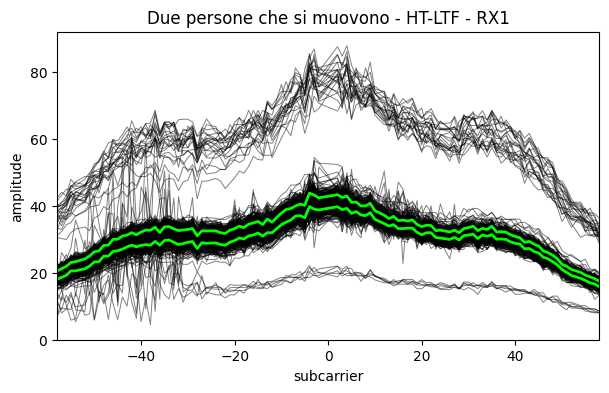

In [31]:
ax= plot_csi_bundle(bundles_due_movimento_htltf[2], subcarrier_idx=subcarriers_htltf, title='Due persone che si muovono - HT-LTF - RX1')

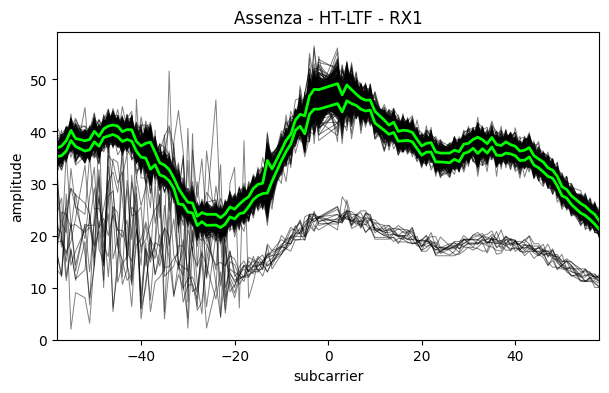

In [32]:
ax= plot_csi_bundle(bundles_assenza_htltf[1], subcarrier_idx=subcarriers_htltf, title='Assenza - HT-LTF - RX1')

In [33]:
def extract_features_per_subcarrier(csi_matrix):
    """
    csi_matrix: array (N_win, N_subcarriers)
    Output: dict con feature vettoriali (shape (N_win, N_subcarriers))

    """
    feats = {}
    
    feats["std"] = np.std(csi_matrix, axis=0)   # per subcarrier, quindi nella prima finestra calcolo la deviazine su tutta la finestra e cosi via
    feats["min"] = np.min(csi_matrix, axis=0)
    feats["max"] = np.max(csi_matrix, axis=0)
    feats["avg"] = np.mean(csi_matrix, axis=0)
    feats["qtl"] = np.percentile(csi_matrix, 25, axis=0)
    feats["qtu"] = np.percentile(csi_matrix, 75, axis=0)
    feats["iqr"] = feats["qtu"] - feats["qtl"]
    
    return feats


In [34]:
def extract_adj_feature_all_windows(csi_windows, N=2):
    """
    Calcola la feature 'adj' per ciascuna finestra CSI (come nel paper Wi-CaL).
    
    Parametri
    ----------
    csi_windows : list of np.ndarray
        Ogni elemento è una matrice (N_pkt, N_subcarriers)
    N : int
        Numero di sottocarrier adiacenti da considerare su ciascun lato

    Ritorna
    -------
    adj_all : list of np.ndarray
        Lista di vettori (uno per finestra), ciascuno lungo (N_subcarriers - 2*N)
    """
    adj_all = []
    for w, csi_matrix in enumerate(csi_windows):
        n_pkt, n_subc = csi_matrix.shape
        adj_values = []

        for j in range(N, n_subc - N):  # evitiamo i bordi
            xi_j = np.zeros(n_pkt)
            for n in range(1, N + 1):
                xi_j += np.abs(csi_matrix[:, j] - csi_matrix[:, j - n])
                xi_j += np.abs(csi_matrix[:, j] - csi_matrix[:, j + n])
            mu_j = np.mean(xi_j)
            adj_values.append(mu_j)

        adj_all.append(np.array(adj_values))
    return adj_all


In [35]:
def extract_euc_feature_all_windows(csi_windows):
    """
    Calcola la feature 'euc' (Euclidean distance tra pacchetti consecutivi)
    per ciascuna finestra CSI, come da paper Wi-CaL.

    Parametri
    ----------
    csi_windows : list of np.ndarray
        Ogni elemento è una matrice (N_pkt, N_subcarriers)

    Ritorna
    -------
    euc_all : list of float
        Lista di valori 'euc', uno per finestra
    """
    euc_all = []

    for w, csi_matrix in enumerate(csi_windows):
        if csi_matrix.shape[0] < 2:
            euc_all.append(np.nan)  # finestra troppo corta, eviti errore
            continue

        # Differenze tra pacchetti consecutivi
        diffs = np.diff(csi_matrix, axis=0)            # shape (N_pkt-1, N_subcarriers)
        norms = np.linalg.norm(diffs, axis=1)          # distanza euclidea per ogni coppia
        euc_val = np.median(norms)                     # mediana come nel paper

        euc_all.append(euc_val)

    return np.array(euc_all)


In [36]:
#caloclo la feature adj per ogni condizione e per ogni ricevitore LLTF
adj_assenza_lltf = extract_adj_feature_all_windows(bundles_assenza_lltf, N=2)
df_adj_assenza_lltf = pd.DataFrame(adj_assenza_lltf)
assenza_adj_lltf = df_adj_assenza_lltf.values.tolist()


adj_due_movimento_lltf = extract_adj_feature_all_windows(bundles_due_movimento_lltf, N=2)
df_adj_due_movimento_lltf = pd.DataFrame(adj_due_movimento_lltf)
due_movimento_adj_lltf = df_adj_due_movimento_lltf.values.tolist()


adj_due_ferme_lltf = extract_adj_feature_all_windows(bundles_due_ferme_lltf, N=2)
df_adj_due_ferme_lltf = pd.DataFrame(adj_due_ferme_lltf)
due_ferme_adj_lltf = df_adj_due_ferme_lltf.values.tolist()


adj_una_movimento_lltf = extract_adj_feature_all_windows(bundles_una_movimento_lltf, N=2)
df_adj_una_movimento_lltf = pd.DataFrame(adj_una_movimento_lltf)
una_movimento_adj_lltf = df_adj_una_movimento_lltf.values.tolist()


adj_una_ferma_lltf = extract_adj_feature_all_windows(bundles_una_ferma_lltf, N=2)
df_adj_una_ferma_lltf = pd.DataFrame(adj_una_ferma_lltf)
una_ferma_adj_lltf = df_adj_una_ferma_lltf.values.tolist()

adj_una_entra_esce_lltf = extract_adj_feature_all_windows(bundles_una_entra_esce_lltf, N=2)
df_adj_una_entra_esce_lltf = pd.DataFrame(adj_una_entra_esce_lltf)
una_entra_esce_adj_lltf = df_adj_una_entra_esce_lltf.values.tolist()




In [37]:
#caloclo la feature adj per ogni condizione e per ogni ricevitore htltf
adj_assenza_htltf = extract_adj_feature_all_windows(bundles_assenza_htltf, N=2)
df_adj_assenza_htltf = pd.DataFrame(adj_assenza_htltf)
assenza_adj_htltf = df_adj_assenza_htltf.values.tolist()


adj_due_movimento_htltf = extract_adj_feature_all_windows(bundles_due_movimento_htltf, N=2)
df_adj_due_movimento_htltf = pd.DataFrame(adj_due_movimento_htltf)
due_movimento_adj_htltf = df_adj_due_movimento_htltf.values.tolist()


adj_due_ferme_htltf = extract_adj_feature_all_windows(bundles_due_ferme_htltf, N=2)
df_adj_due_ferme_htltf = pd.DataFrame(adj_due_ferme_htltf)
due_ferme_adj_htltf = df_adj_due_ferme_htltf.values.tolist()


adj_una_movimento_htltf = extract_adj_feature_all_windows(bundles_una_movimento_htltf, N=2)
df_adj_una_movimento_htltf = pd.DataFrame(adj_una_movimento_htltf)
una_movimento_adj_htltf = df_adj_una_movimento_htltf.values.tolist()


adj_una_ferma_htltf = extract_adj_feature_all_windows(bundles_una_ferma_htltf, N=2)
df_adj_una_ferma_htltf = pd.DataFrame(adj_una_ferma_htltf)
una_ferma_adj_htltf = df_adj_una_ferma_htltf.values.tolist()

adj_una_entra_esce_htltf = extract_adj_feature_all_windows(bundles_una_entra_esce_htltf, N=2)
df_adj_una_entra_esce_htltf = pd.DataFrame(adj_una_entra_esce_htltf)
una_entra_esce_adj_htltf = df_adj_una_entra_esce_htltf.values.tolist()


In [38]:
#caloclo la feature euc per ogni condizione e per ogni ricevitore LLTF
euc_assenza_lltf = extract_euc_feature_all_windows(bundles_assenza_lltf)
df_euc_assenza_lltf = pd.DataFrame(euc_assenza_lltf)


euc_due_movimento_lltf = extract_euc_feature_all_windows(bundles_due_movimento_lltf)
df_euc_due_movimento_lltf = pd.DataFrame(euc_due_movimento_lltf)


euc_due_ferme_lltf = extract_euc_feature_all_windows(bundles_due_ferme_lltf)
df_euc_due_ferme_lltf = pd.DataFrame(euc_due_ferme_lltf)


euc_una_movimento_lltf = extract_euc_feature_all_windows(bundles_una_movimento_lltf)
df_euc_una_movimento_lltf = pd.DataFrame(euc_una_movimento_lltf)


euc_una_ferma_lltf = extract_euc_feature_all_windows(bundles_una_ferma_lltf)
df_euc_una_ferma_lltf = pd.DataFrame(euc_una_ferma_lltf)

euc_una_entra_esce_lltf = extract_euc_feature_all_windows(bundles_una_entra_esce_lltf)
df_euc_una_entra_esce_lltf = pd.DataFrame(euc_una_entra_esce_lltf)

In [39]:
#caloclo la feature euc per ogni condizione e per ogni ricevitore htltf
euc_assenza_htltf = extract_euc_feature_all_windows(bundles_assenza_htltf)
df_euc_assenza_htltf = pd.DataFrame(euc_assenza_htltf)

euc_due_movimento_htltf = extract_euc_feature_all_windows(bundles_due_movimento_htltf)
df_euc_due_movimento_htltf = pd.DataFrame(euc_due_movimento_htltf)


euc_due_ferme_htltf = extract_euc_feature_all_windows(bundles_due_ferme_htltf)
df_euc_due_ferme_htltf = pd.DataFrame(euc_due_ferme_htltf)

euc_una_movimento_htltf = extract_euc_feature_all_windows(bundles_una_movimento_htltf)
df_euc_una_movimento_htltf = pd.DataFrame(euc_una_movimento_htltf)

euc_una_ferma_htltf = extract_euc_feature_all_windows(bundles_una_ferma_htltf)
df_euc_una_ferma_htltf = pd.DataFrame(euc_una_ferma_htltf)

euc_una_entra_esce_htltf = extract_euc_feature_all_windows(bundles_una_entra_esce_htltf)
df_euc_una_entra_esce_htltf = pd.DataFrame(euc_una_entra_esce_htltf)


In [40]:
# calcolo prima le feature come std, min, max, avg etc LLTF

features_assenza_lltf = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_lltf]
df_features_assenza_lltf = pd.DataFrame(features_assenza_lltf)
df_features_assenza_lltf["adj"] = assenza_adj_lltf


features_unapersonaferma = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_lltf]
df_features_una_ferma_lltf = pd.DataFrame(features_unapersonaferma)
df_features_una_ferma_lltf["adj"] = una_ferma_adj_lltf


features_unapersonachesimuove = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_lltf]
df_features_una_movimento_lltf = pd.DataFrame(features_unapersonachesimuove)
df_features_una_movimento_lltf["adj"] = una_movimento_adj_lltf


features_duepersoneferma = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_lltf]
df_features_due_ferme_lltf = pd.DataFrame(features_duepersoneferma)
df_features_due_ferme_lltf["adj"] = due_ferme_adj_lltf


features_duepersonechesimuovono = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_lltf]
df_features_due_movimento_lltf = pd.DataFrame(features_duepersonechesimuovono)
df_features_due_movimento_lltf["adj"] = due_movimento_adj_lltf

features_unapersonaentraesce = [extract_features_per_subcarrier(mat) for mat in bundles_una_entra_esce_lltf]
df_features_una_entra_esce_lltf = pd.DataFrame(features_unapersonaentraesce)
df_features_una_entra_esce_lltf["adj"] = una_entra_esce_adj_lltf


In [41]:
# calcolo prima le feature come std, min, max, avg etc HTLTF

features_assenza_htltf = [extract_features_per_subcarrier(mat) for mat in bundles_assenza_htltf]
df_features_assenza_htltf = pd.DataFrame(features_assenza_htltf)
df_features_assenza_htltf["adj"] = assenza_adj_htltf # adj viene calcolata in maniera diversa per questo in questa fase la aggiungo manualmente


features_unapersonaferma = [extract_features_per_subcarrier(mat) for mat in bundles_una_ferma_htltf]
df_features_una_ferma_htltf = pd.DataFrame(features_unapersonaferma)
df_features_una_ferma_htltf["adj"] = una_ferma_adj_htltf


features_unapersonachesimuove = [extract_features_per_subcarrier(mat) for mat in bundles_una_movimento_htltf]
df_features_una_movimento_htltf = pd.DataFrame(features_unapersonachesimuove)
df_features_una_movimento_htltf["adj"] = una_movimento_adj_htltf


features_duepersoneferma = [extract_features_per_subcarrier(mat) for mat in bundles_due_ferme_htltf]
df_features_due_ferme_htltf = pd.DataFrame(features_duepersoneferma)
df_features_due_ferme_htltf["adj"] = due_ferme_adj_htltf


features_duepersonechesimuovono = [extract_features_per_subcarrier(mat) for mat in bundles_due_movimento_htltf]
df_features_due_movimento_htltf = pd.DataFrame(features_duepersonechesimuovono)
df_features_due_movimento_htltf["adj"] = due_movimento_adj_htltf

features_unapersonaentraesce = [extract_features_per_subcarrier(mat) for mat in bundles_una_entra_esce_htltf]
df_features_una_entra_esce_htltf = pd.DataFrame(features_unapersonaentraesce)
df_features_una_entra_esce_htltf["adj"] = una_entra_esce_adj_htltf


In [42]:
std_values = np.array([f["std"] for f in features_assenza_htltf])
print("Forma:", std_values.shape)
print("lunghezza bundle:", len(bundles_assenza_htltf))
print("lunghezza singolo valore di std, sarebbe std^(w): ", len(std_values[1]))
print("Valori della colonna std", std_values) #compone la prima colonna della matrice, questo è link 1 quindi kw=1


Forma: (185, 108)
lunghezza bundle: 185
lunghezza singolo valore di std, sarebbe std^(w):  108
Valori della colonna std [[2.98635732 3.6305916  3.72751791 ... 2.2722198  2.29247112 2.16681246]
 [2.80671569 3.24478031 3.22521618 ... 2.25912785 2.25960859 2.09096991]
 [3.17517809 3.15132186 3.76075067 ... 2.51474051 2.40601987 2.293954  ]
 ...
 [2.41314319 2.9348352  2.18207548 ... 1.78345404 1.71957259 1.69033154]
 [2.61587083 2.70921801 2.42619791 ... 2.14372001 2.10389985 1.97437953]
 [3.13264866 2.99357552 2.69350942 ... 2.19529599 2.19027053 2.05660361]]


In [43]:
matrice_min_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['min'].to_list())
matrice_max_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['max'].to_list())
matrice_std_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['std'].to_list())
matrice_avg_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['avg'].to_list())
matrice_qtl_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['qtl'].to_list())
matrice_qtu_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['qtu'].to_list())
matrice_iqr_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['iqr'].to_list())
matrice_adj_assenza_htltf = pd.DataFrame(df_features_assenza_htltf['adj'].to_list())
matrice_euc_assenza_htltf = df_euc_assenza_htltf

matrice_min_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['min'].to_list())
matrice_max_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['max'].to_list())
matrice_std_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['std'].to_list())
matrice_avg_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['avg'].to_list())
matrice_qtl_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['qtl'].to_list())
matrice_qtu_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['qtu'].to_list())
matrice_iqr_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['iqr'].to_list())
matrice_adj_una_ferma_htltf = pd.DataFrame(df_features_una_ferma_htltf['adj'].to_list())
matrice_euc_una_ferma_htltf = df_euc_una_ferma_htltf

matrice_min_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['min'].to_list())
matrice_max_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['max'].to_list())
matrice_std_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['std'].to_list())
matrice_avg_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['avg'].to_list())
matrice_qtl_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['qtl'].to_list())
matrice_qtu_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['qtu'].to_list())
matrice_iqr_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['iqr'].to_list())
matrice_adj_una_movimento_htltf = pd.DataFrame(df_features_una_movimento_htltf['adj'].to_list())
matrice_euc_una_movimento_htltf = df_euc_una_movimento_htltf

matrice_min_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['min'].to_list())
matrice_max_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['max'].to_list())
matrice_std_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['std'].to_list())
matrice_avg_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['avg'].to_list())
matrice_qtl_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['qtl'].to_list())
matrice_qtu_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['qtu'].to_list())
matrice_iqr_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['iqr'].to_list())
matrice_adj_due_movimento_htltf = pd.DataFrame(df_features_due_movimento_htltf['adj'].to_list())
matrice_euc_due_movimento_htltf = df_euc_due_movimento_htltf

matrice_min_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['min'].to_list())
matrice_max_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['max'].to_list())
matrice_std_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['std'].to_list())
matrice_avg_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['avg'].to_list())
matrice_qtl_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['qtl'].to_list())
matrice_qtu_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['qtu'].to_list())
matrice_iqr_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['iqr'].to_list())
matrice_adj_due_ferme_htltf = pd.DataFrame(df_features_due_ferme_htltf['adj'].to_list())
matrice_euc_due_ferme_htltf = df_euc_due_ferme_htltf

matrice_min_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['min'].to_list())
matrice_max_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['max'].to_list())
matrice_std_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['std'].to_list())
matrice_avg_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['avg'].to_list())
matrice_qtl_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['qtl'].to_list())
matrice_qtu_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['qtu'].to_list())
matrice_iqr_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['iqr'].to_list())
matrice_adj_una_entra_esce_htltf = pd.DataFrame(df_features_una_entra_esce_htltf['adj'].to_list())
matrice_euc_una_entra_esce_htltf = df_euc_una_entra_esce_htltf

In [44]:
matrice_min_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['min'].to_list())
matrice_max_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['max'].to_list())
matrice_std_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['std'].to_list())
matrice_avg_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['avg'].to_list())
matrice_qtl_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['qtl'].to_list())
matrice_qtu_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['qtu'].to_list())
matrice_iqr_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['iqr'].to_list())
matrice_adj_assenza_lltf = pd.DataFrame(df_features_assenza_lltf['adj'].to_list())
matrice_euc_assenza_lltf = df_euc_assenza_lltf

matrice_min_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['min'].to_list())
matrice_max_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['max'].to_list())
matrice_std_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['std'].to_list())
matrice_avg_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['avg'].to_list())
matrice_qtl_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['qtl'].to_list())
matrice_qtu_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['qtu'].to_list())
matrice_iqr_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['iqr'].to_list())
matrice_adj_una_ferma_lltf = pd.DataFrame(df_features_una_ferma_lltf['adj'].to_list())
matrice_euc_una_ferma_lltf = df_euc_una_ferma_lltf

matrice_min_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['min'].to_list())
matrice_max_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['max'].to_list())
matrice_std_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['std'].to_list())
matrice_avg_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['avg'].to_list())
matrice_qtl_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['qtl'].to_list())
matrice_qtu_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['qtu'].to_list())
matrice_iqr_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['iqr'].to_list())
matrice_adj_una_movimento_lltf = pd.DataFrame(df_features_una_movimento_lltf['adj'].to_list())
matrice_euc_una_movimento_lltf = df_euc_una_movimento_lltf

matrice_min_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['min'].to_list())
matrice_max_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['max'].to_list())
matrice_std_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['std'].to_list())
matrice_avg_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['avg'].to_list())
matrice_qtl_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['qtl'].to_list())
matrice_qtu_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['qtu'].to_list())
matrice_iqr_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['iqr'].to_list())
matrice_adj_due_movimento_lltf = pd.DataFrame(df_features_due_movimento_lltf['adj'].to_list())
matrice_euc_due_movimento_lltf = df_euc_due_movimento_lltf

matrice_min_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['min'].to_list())
matrice_max_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['max'].to_list())
matrice_std_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['std'].to_list())
matrice_avg_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['avg'].to_list())
matrice_qtl_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['qtl'].to_list())
matrice_qtu_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['qtu'].to_list())
matrice_iqr_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['iqr'].to_list())
matrice_adj_due_ferme_lltf = pd.DataFrame(df_features_due_ferme_lltf['adj'].to_list())
matrice_euc_due_ferme_lltf = df_euc_due_ferme_lltf

matrice_min_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['min'].to_list())
matrice_max_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['max'].to_list())
matrice_std_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['std'].to_list())
matrice_avg_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['avg'].to_list())
matrice_qtl_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['qtl'].to_list())
matrice_qtu_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['qtu'].to_list())
matrice_iqr_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['iqr'].to_list())
matrice_adj_una_entra_esce_lltf = pd.DataFrame(df_features_una_entra_esce_lltf['adj'].to_list())
matrice_euc_una_entra_esce_lltf = df_euc_una_entra_esce_lltf

* inizio con creazione dataset 

In [113]:
matrice_assenza_lltf = pd.concat([
    matrice_min_assenza_lltf,
    matrice_max_assenza_lltf,
    matrice_std_assenza_lltf,
    matrice_avg_assenza_lltf,
    matrice_qtl_assenza_lltf,
    matrice_qtu_assenza_lltf,
    matrice_iqr_assenza_lltf,
    matrice_adj_assenza_lltf,
    matrice_euc_assenza_lltf
], axis=1)

matrice_assenza_lltf["target"] = 0

matrice_una_ferma_lltf = pd.concat([
    matrice_min_una_ferma_lltf,
    matrice_max_una_ferma_lltf,
    matrice_std_una_ferma_lltf,
    matrice_avg_una_ferma_lltf,
    matrice_qtl_una_ferma_lltf,
    matrice_qtu_una_ferma_lltf,
    matrice_iqr_una_ferma_lltf,
    matrice_adj_una_ferma_lltf,
    matrice_euc_una_ferma_lltf
], axis=1)

matrice_una_ferma_lltf["target"] = 1

matrice_una_movimento_lltf = pd.concat([
    matrice_min_una_movimento_lltf,
    matrice_max_una_movimento_lltf,
    matrice_std_una_movimento_lltf,
    matrice_avg_una_movimento_lltf,
    matrice_qtl_una_movimento_lltf,
    matrice_qtu_una_movimento_lltf,
    matrice_iqr_una_movimento_lltf,
    matrice_adj_una_movimento_lltf,
    matrice_euc_una_movimento_lltf
], axis=1)

matrice_una_movimento_lltf["target"] = 2

matrice_due_ferme_lltf = pd.concat([
    matrice_min_due_ferme_lltf,
    matrice_max_due_ferme_lltf,
    matrice_std_due_ferme_lltf,
    matrice_avg_due_ferme_lltf,
    matrice_qtl_due_ferme_lltf,
    matrice_qtu_due_ferme_lltf,
    matrice_iqr_due_ferme_lltf,
    matrice_adj_due_ferme_lltf,
    matrice_euc_due_ferme_lltf
], axis=1)

matrice_due_ferme_lltf["target"] = 3

matrice_due_movimento_lltf = pd.concat([
    matrice_min_due_movimento_lltf,
    matrice_max_due_movimento_lltf,
    matrice_std_due_movimento_lltf,
    matrice_avg_due_movimento_lltf,
    matrice_qtl_due_movimento_lltf,
    matrice_qtu_due_movimento_lltf,
    matrice_iqr_due_movimento_lltf,
    matrice_adj_due_movimento_lltf,
    matrice_euc_due_movimento_lltf
], axis=1)

matrice_due_movimento_lltf["target"] = 4

In [114]:
matrice_assenza_htltf = pd.concat([
    matrice_min_assenza_htltf,
    matrice_max_assenza_htltf,
    matrice_std_assenza_htltf,
    matrice_avg_assenza_htltf,
    matrice_qtl_assenza_htltf,
    matrice_qtu_assenza_htltf,
    matrice_iqr_assenza_htltf,
    matrice_adj_assenza_htltf,
    matrice_euc_assenza_htltf
], axis=1)

matrice_assenza_htltf["target"] = 0

matrice_una_ferma_htltf = pd.concat([
    matrice_min_una_ferma_htltf,
    matrice_max_una_ferma_htltf,
    matrice_std_una_ferma_htltf,
    matrice_avg_una_ferma_htltf,
    matrice_qtl_una_ferma_htltf,
    matrice_qtu_una_ferma_htltf,
    matrice_iqr_una_ferma_htltf,
    matrice_adj_una_ferma_htltf,
    matrice_euc_una_ferma_htltf
], axis=1)

matrice_una_ferma_htltf["target"] = 1

matrice_una_movimento_htltf = pd.concat([
    matrice_min_una_movimento_htltf,
    matrice_max_una_movimento_htltf,
    matrice_std_una_movimento_htltf,
    matrice_avg_una_movimento_htltf,
    matrice_qtl_una_movimento_htltf,
    matrice_qtu_una_movimento_htltf,
    matrice_iqr_una_movimento_htltf,
    matrice_adj_una_movimento_htltf,
    matrice_euc_una_movimento_htltf
], axis=1)

matrice_una_movimento_htltf["target"] = 2

matrice_due_ferme_htltf = pd.concat([
    matrice_min_due_ferme_htltf,
    matrice_max_due_ferme_htltf,
    matrice_std_due_ferme_htltf,
    matrice_avg_due_ferme_htltf,
    matrice_qtl_due_ferme_htltf,
    matrice_qtu_due_ferme_htltf,
    matrice_iqr_due_ferme_htltf,
    matrice_adj_due_ferme_htltf,
    matrice_euc_due_ferme_htltf
], axis=1)

matrice_due_ferme_htltf["target"] = 3

matrice_due_movimento_htltf = pd.concat([
    matrice_min_due_movimento_htltf,
    matrice_max_due_movimento_htltf,
    matrice_std_due_movimento_htltf,
    matrice_avg_due_movimento_htltf,
    matrice_qtl_due_movimento_htltf,
    matrice_qtu_due_movimento_htltf,
    matrice_iqr_due_movimento_htltf,
    matrice_adj_due_movimento_htltf,
    matrice_euc_due_movimento_htltf
], axis=1)

matrice_due_movimento_htltf["target"] = 4

In [123]:
matrice_assenza_htltf = pd.concat([
    matrice_min_assenza_htltf
], axis=1)

matrice_assenza_htltf["target"] = 0

matrice_una_ferma_htltf = pd.concat([
    matrice_min_una_ferma_htltf
], axis=1)

matrice_una_ferma_htltf["target"] = 1

matrice_una_movimento_htltf = pd.concat([
    matrice_min_una_movimento_htltf
], axis=1)

matrice_una_movimento_htltf["target"] = 2

matrice_due_ferme_htltf = pd.concat([
    matrice_min_due_ferme_htltf
], axis=1)

matrice_due_ferme_htltf["target"] = 3

matrice_due_movimento_htltf = pd.concat([
    matrice_min_due_movimento_htltf
], axis=1)

matrice_due_movimento_htltf["target"] = 4

In [124]:
matrice_assenza_lltf = pd.concat([
    matrice_min_assenza_lltf
], axis=1)

matrice_assenza_lltf["target"] = 0

matrice_una_ferma_lltf = pd.concat([
    matrice_min_una_ferma_lltf
], axis=1)

matrice_una_ferma_lltf["target"] = 1

matrice_una_movimento_lltf = pd.concat([
    matrice_min_una_movimento_lltf
], axis=1)

matrice_una_movimento_lltf["target"] = 2

matrice_due_ferme_lltf = pd.concat([
    matrice_min_due_ferme_lltf
], axis=1)

matrice_due_ferme_lltf["target"] = 3

matrice_due_movimento_lltf = pd.concat([
    matrice_min_due_movimento_lltf
], axis=1)

matrice_due_movimento_lltf["target"] = 4

In [125]:
dataset_finale_lltf = pd.concat([
    matrice_assenza_lltf,
    matrice_una_ferma_lltf,
    matrice_una_movimento_lltf,
    matrice_due_ferme_lltf,
    matrice_due_movimento_lltf
], axis=0).reset_index(drop=True)

dataset_finale_htltf = pd.concat([
    matrice_assenza_htltf,
    matrice_una_ferma_htltf,
    matrice_una_movimento_htltf,
    matrice_due_ferme_htltf,
    matrice_due_movimento_htltf
], axis=0).reset_index(drop=True)



In [126]:
dataset_finale_lltf 


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,target
0,21.260292,21.260292,21.400935,20.518285,20.124612,19.235384,19.209373,19.209373,18.681542,18.027756,...,12.806248,12.806248,11.661904,11.661904,11.180340,11.045361,9.848858,10.198039,9.486833,0
1,21.260292,20.880613,21.400935,21.189620,19.697716,19.235384,19.209373,19.209373,19.026298,18.110770,...,12.806248,12.529964,12.041595,11.661904,11.180340,10.770330,10.630146,10.198039,9.433981,0
2,21.470911,20.615528,21.470911,21.023796,19.697716,19.416488,19.235384,18.973666,18.439089,18.027756,...,13.152946,12.529964,12.000000,12.000000,10.770330,10.630146,10.816654,10.000000,9.433981,0
3,21.954498,20.615528,21.213203,21.023796,20.000000,19.416488,19.416488,18.973666,18.439089,18.027756,...,13.038405,13.000000,12.000000,12.000000,10.770330,10.630146,10.770330,10.000000,8.944272,0
4,22.000000,20.591260,20.396078,21.095023,20.000000,19.723083,19.209373,19.026298,19.209373,18.110770,...,13.038405,12.649111,12.083046,12.000000,10.816654,10.816654,10.630146,10.198039,8.944272,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,11.180340,11.313708,11.401754,11.661904,11.401754,11.180340,11.401754,11.045361,10.630146,10.295630,...,7.810250,7.211103,7.071068,7.000000,6.324555,6.324555,6.082763,5.830952,5.656854,4
1074,11.401754,11.704700,12.041595,12.206556,11.401754,11.180340,11.401754,11.180340,11.180340,10.816654,...,7.615773,7.211103,7.000000,7.000000,6.403124,6.082763,6.082763,5.830952,5.656854,4
1075,12.529964,12.041595,12.041595,12.206556,12.206556,11.401754,11.401754,11.661904,11.401754,10.816654,...,7.071068,6.082763,6.324555,6.403124,5.830952,5.656854,6.000000,5.385165,5.000000,4
1076,12.806248,12.806248,13.038405,12.806248,12.529964,12.165525,12.165525,12.000000,11.401754,11.180340,...,7.071068,6.082763,6.324555,6.403124,5.830952,5.656854,6.000000,5.385165,5.000000,4


In [101]:
dataset_finale_lltf 


,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,target
0,21.260292,21.260292,21.400935,20.518285,20.124612,19.235384,19.209373,19.209373,18.681542,18.027756,...,17.691806,17.492856,16.031220,16.492423,15.811388,15.264338,14.866069,14.764823,13.601471,0
1,21.260292,20.880613,21.400935,21.189620,19.697716,19.235384,19.209373,19.209373,19.026298,18.110770,...,17.888544,17.720045,16.643317,16.278821,15.811388,15.524175,14.866069,14.422205,13.601471,0
2,21.470911,20.615528,21.470911,21.023796,19.697716,19.416488,19.235384,18.973666,18.439089,18.027756,...,18.110770,17.720045,16.643317,16.278821,15.620499,15.524175,14.866069,14.422205,14.000000,0
3,21.954498,20.615528,21.213203,21.023796,20.000000,19.416488,19.416488,18.973666,18.439089,18.027756,...,18.110770,17.088007,16.155494,16.155494,15.620499,15.264338,15.000000,14.764823,14.000000,0
4,22.000000,20.591260,20.396078,21.095023,20.000000,19.723083,19.209373,19.026298,19.209373,18.110770,...,17.691806,17.088007,16.124515,16.155494,15.620499,15.811388,15.000000,14.764823,13.892444,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,11.180340,11.313708,11.401754,11.661904,11.401754,11.180340,11.401754,11.045361,10.630146,10.295630,...,11.704700,11.401754,11.045361,10.440307,10.440307,10.000000,10.049876,10.000000,9.219544,4
1074,11.401754,11.704700,12.041595,12.206556,11.401754,11.180340,11.401754,11.180340,11.180340,10.816654,...,12.041595,11.401754,11.401754,10.630146,10.816654,10.630146,10.198039,10.198039,9.219544,4
1075,12.529964,12.041595,12.041595,12.206556,12.206556,11.401754,11.401754,11.661904,11.401754,10.816654,...,12.041595,11.401754,11.401754,10.630146,10.816654,10.630146,10.198039,10.198039,9.219544,4
1076,12.806248,12.806248,13.038405,12.806248,12.529964,12.165525,12.165525,12.000000,11.401754,11.180340,...,11.401754,11.401754,10.440307,10.295630,10.295630,10.049876,9.899495,10.000000,9.219544,4


In [92]:
dataset_finale_htltf

,0,1,2,3,4,5,6,7,8,9,...,99,100,101,102,103,104,105,106,107,target
0,10.198039,5.830952,8.062258,7.071068,11.704700,2.236068,9.486833,5.385165,5.385165,11.401754,...,33.301652,32.015621,31.400637,30.016662,28.635642,28.160256,27.018512,26.570661,26.172505,0
1,13.416408,12.083046,11.313708,2.000000,9.055385,8.062258,3.162278,13.892444,17.464249,10.000000,...,34.132096,32.015621,31.400637,30.016662,28.635642,28.160256,27.294688,26.570661,25.298221,0
2,10.000000,12.083046,8.062258,2.000000,9.055385,2.236068,3.162278,3.162278,15.132746,10.000000,...,34.132096,32.249031,31.622777,29.732137,29.154759,28.017851,27.658633,26.305893,25.000000,0
3,10.000000,12.649111,8.062258,10.440307,16.000000,2.236068,10.816654,3.162278,12.041595,13.038405,...,33.421550,32.249031,31.622777,30.413813,29.154759,28.017851,27.658633,26.400758,25.019992,0
4,10.198039,6.324555,12.041595,10.440307,17.088007,13.152946,2.000000,15.132746,5.000000,16.401219,...,33.421550,32.310989,31.780497,30.413813,29.154759,27.730849,27.073973,26.400758,25.317978,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,6.082763,7.071068,1.414214,2.236068,6.403124,3.605551,2.828427,5.099020,9.219544,12.041595,...,43.324358,41.146081,39.408121,39.000000,36.878178,36.878178,35.510562,34.655447,32.557641,4
1074,6.082763,7.071068,4.242641,5.000000,7.280110,10.816654,2.828427,1.000000,14.212670,12.727922,...,46.872167,42.801869,41.036569,40.311289,39.115214,38.288379,37.000000,35.902646,34.000000,4
1075,3.162278,1.414214,4.242641,10.198039,5.000000,6.324555,5.099020,1.000000,12.165525,12.727922,...,46.872167,42.801869,41.036569,40.311289,39.115214,38.288379,37.000000,35.902646,34.000000,4
1076,3.162278,1.414214,4.242641,8.000000,5.000000,6.324555,5.099020,6.403124,9.486833,14.035669,...,44.000000,40.792156,39.824616,38.418745,36.496575,36.878178,36.235342,34.713110,33.421550,4


In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)


In [94]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.pipeline import Pipeline

# Nuove metriche per la regressione

In [95]:
def train_classifiers_2(dataset, target_col="target", titolo_suffix="Confusion Matrices"):

    X = dataset.drop(columns=[target_col])
    y = dataset[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    models = {
        "SVM (RBF)": SVC(kernel="rbf", C=10, gamma="scale"),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
        "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42,
                                 use_label_encoder=False, eval_metric='mlogloss'),
        "LightGBM": LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=42),
        "GBDT": GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
    }

    # Risultati
    f1_results = {}
    accuracy_results = {}
    time_results = {}
    metrics_table = []

    # -------------------------------
    # FIGURA UNICA DELLE CONFUSION MATRIX
    # -------------------------------
    n_models = len(models)
    n_cols = 3
    n_rows = math.ceil(n_models / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5*n_rows))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):

        # --- TEMPO DI TRAINING ---
        start = time.perf_counter()
        model.fit(X_train, y_train)
        train_time = time.perf_counter() - start
        time_results[name] = train_time

        # Predizione
        y_pred = model.predict(X_test)

        # Accuracy
        accuracy_results[name] = accuracy_score(y_test, y_pred)

        # Report
        report_dict = classification_report(y_test, y_pred, output_dict=True)
        f1_macro = report_dict["macro avg"]["f1-score"]
        f1_results[name] = f1_macro

        # METRICHE DETTAGLIATE
        for label, values in report_dict.items():
            if label.isdigit():
                metrics_table.append({
                    "Model": name,
                    "Class": label,
                    "Precision": values["precision"],
                    "Recall": values["recall"],
                    "F1-score": values["f1-score"],
                    "Support": values["support"],
                    "Train_time_sec": train_time
                })

        # Confusion matrix
        ax = axes[idx]
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f",
                    cmap="Blues", ax=ax)
        ax.set_title(f"{name}\nTraining time: {train_time:.3f} sec  | F1-macro: {f1_macro:.3f} | Accuracy: {accuracy_results[name]:.3f}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")

    # Rimuove subplot vuoti
    for i in range(idx+1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig(f"{titolo_suffix}.png", dpi=300)
    plt.show()
    print(f"\n📁 Confusion matrices salvate in:{titolo_suffix}.png")

    # -------------------------------
    # TABELLA RIASSUNTIVA ORDINATA PER F1 MACRO
    # -------------------------------
    f1_df = pd.DataFrame(
        {"Model": list(f1_results.keys()), 
         "F1_macro": list(f1_results.values()),
         "Train_time_sec": list(time_results.values())}
    ).sort_values("F1_macro", ascending=False)

    print("\n📊 Summary of F1 Macro scores (+ training time):")
    print(f1_df)



    # -------------------------------
    # TABELLA COMPLETA DELLE METRICHE
    # -------------------------------
    metrics_df = pd.DataFrame(metrics_table)

    print("\n📋 Full Classification Metrics Table (with training times):")
    print(metrics_df)

    return f1_df, metrics_df


In [96]:
import math
import time
import re

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:58:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15054
[LightGBM] [Info] Number of data points in the train set: 754, number of used features: 108
[LightGBM] [Info] Start training from score -1.765580
[LightGBM] [Info] Start training from score -1.634960
[LightGBM] [Info] Start training from score -1.648659
[LightGBM] [Info] Start training from score -1.531642
[LightGBM] [Info] Start training from score -1.489594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


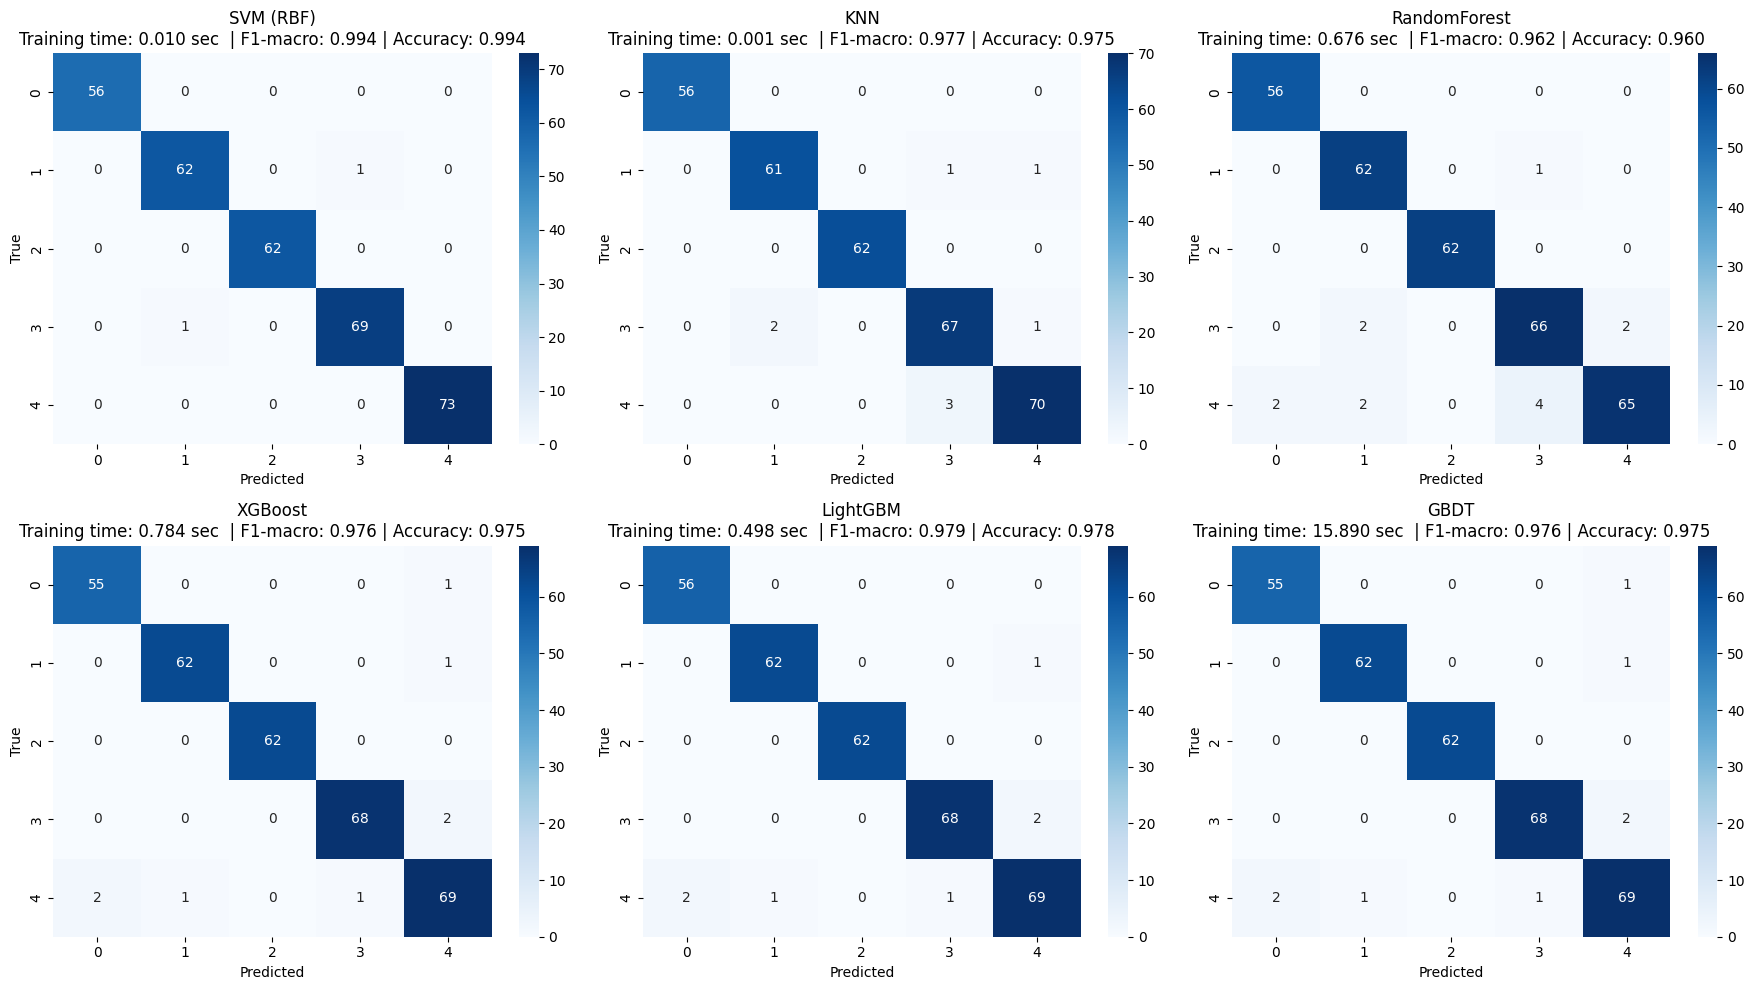


📁 Confusion matrices salvate in:Confusion Matrices HTLTF vecchi dati classi separate con meno feature.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
0     SVM (RBF)  0.993968        0.010051
4      LightGBM  0.979345        0.497727
1           KNN  0.976825        0.000894
3       XGBoost  0.976240        0.784281
5          GBDT  0.976240       15.889600
2  RandomForest  0.961688        0.676234

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     56.0        0.010051
1      SVM (RBF)     1   0.984127  0.984127  0.984127     63.0        0.010051
2      SVM (RBF)     2   1.000000  1.000000  1.000000     62.0        0.010051
3      SVM (RBF)     3   0.985714  0.985714  0.985714     70.0        0.010051
4      SVM (RBF)     4   1.000000  1.000000  1.000000     73.0        0.010051
5            KNN

In [127]:
results_htltf = train_classifiers_2(dataset_finale_htltf,titolo_suffix="Confusion Matrices HTLTF vecchi dati classi separate con meno feature")


c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:52:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12179
[LightGBM] [Info] Number of data points in the train set: 754, number of used features: 104
[LightGBM] [Info] Start training from score -1.765580
[LightGBM] [Info] Start training from score -1.634960
[LightGBM] [Info] Start training from score -1.648659
[LightGBM] [Info] Start training from score -1.531642
[LightGBM] [Info] Start training from score -1.489594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

c:\Users\mariu\Desktop\Borsa\Tesi\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


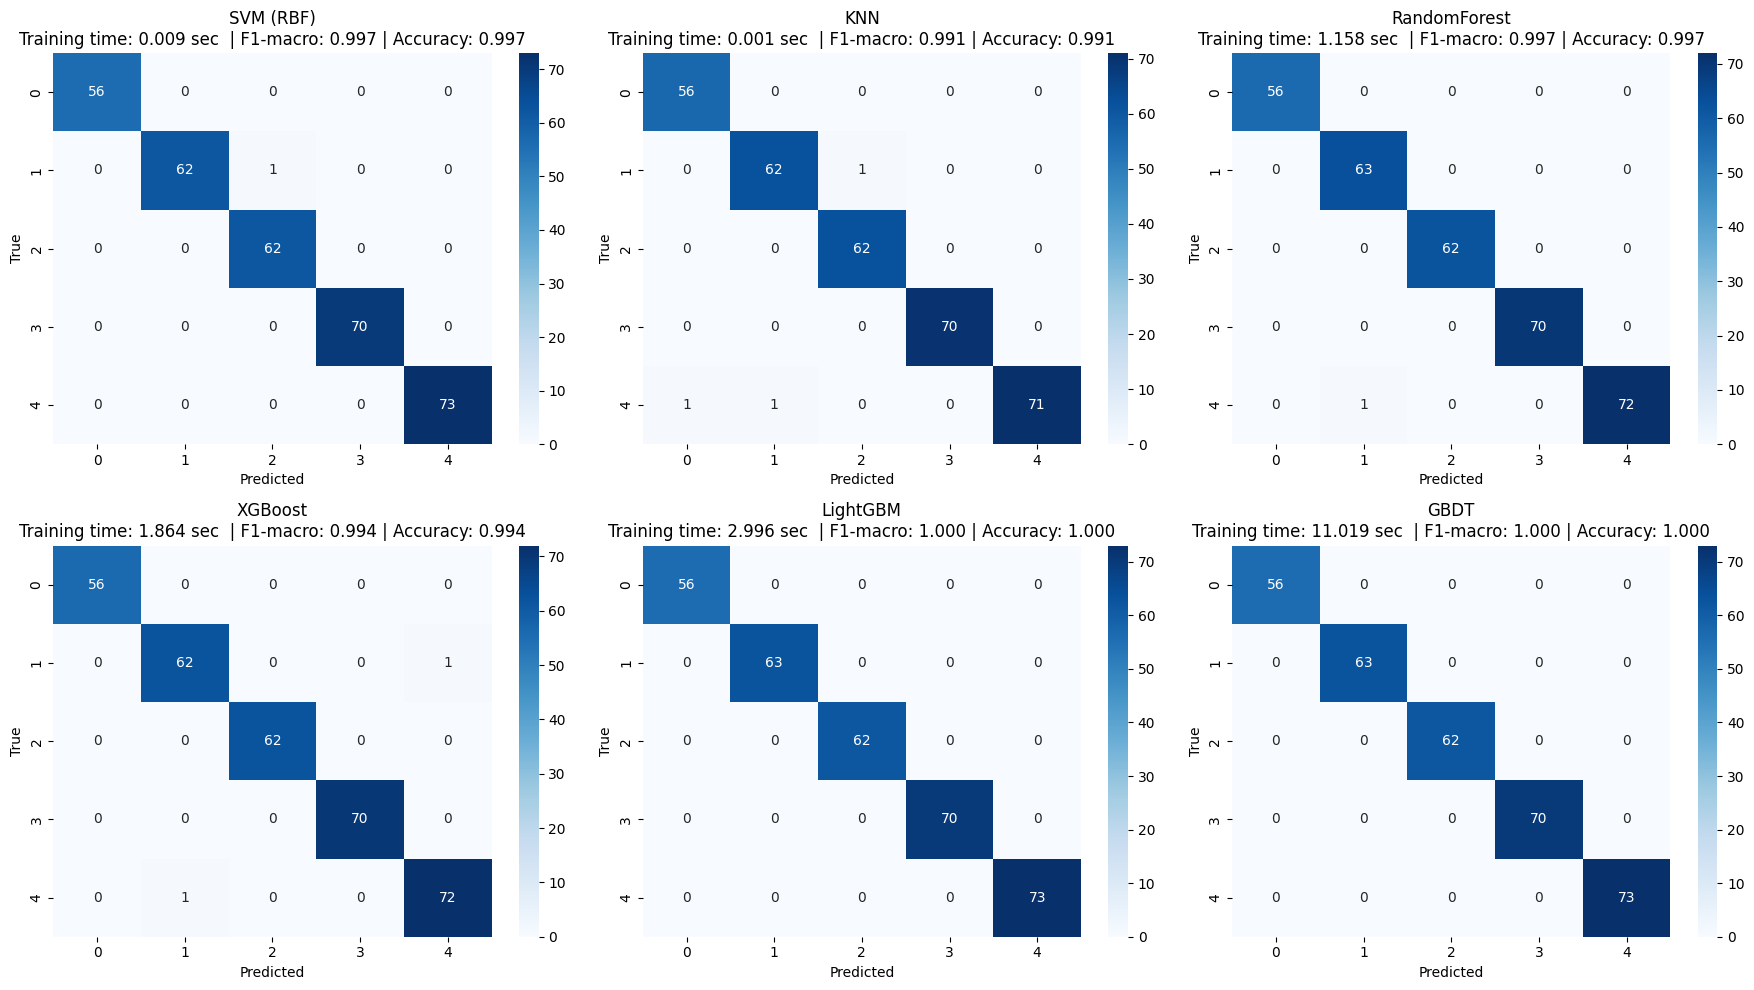


📁 Confusion matrices salvate in:Confusion Matrices LLTF vecchi dati classi separate con meno feature.png

📊 Summary of F1 Macro scores (+ training time):
          Model  F1_macro  Train_time_sec
4      LightGBM  1.000000        2.996054
5          GBDT  1.000000       11.018673
2  RandomForest  0.997046        1.158277
0     SVM (RBF)  0.996800        0.008602
3       XGBoost  0.994086        1.864149
1           KNN  0.990678        0.000771

📋 Full Classification Metrics Table (with training times):
           Model Class  Precision    Recall  F1-score  Support  Train_time_sec
0      SVM (RBF)     0   1.000000  1.000000  1.000000     56.0        0.008602
1      SVM (RBF)     1   1.000000  0.984127  0.992000     63.0        0.008602
2      SVM (RBF)     2   0.984127  1.000000  0.992000     62.0        0.008602
3      SVM (RBF)     3   1.000000  1.000000  1.000000     70.0        0.008602
4      SVM (RBF)     4   1.000000  1.000000  1.000000     73.0        0.008602
5            KNN 

In [98]:
results_lltf = train_classifiers_2(dataset_finale_lltf,titolo_suffix="Confusion Matrices LLTF vecchi dati classi separate con meno feature")


In [99]:
#utilizzo sckit-learn per confronto
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
# Istanziazione del modello SVM con OneVsOneClassifier
#normalizziamo i dati
from sklearn.preprocessing import StandardScaler
# Normalizzazione dei dati 
X = dataset_finale_lltf.drop(columns=["target"])
y = dataset_finale_lltf["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
ovo_svm_sklearn = OneVsOneClassifier(SVC(kernel='rbf', C=10))
# Addestramento del modello
start_time = time.time()
ovo_svm_sklearn.fit(X_train, y_train)
end_time = time.time()
t_train_ovo_sklearn = end_time - start_time
print(f"Tempo di addestramento SVM senza PCA scikit-learn: {t_train_ovo_sklearn:.2f} secondi")
# Predizione sui dati di test
start_time = time.time()
y_pred_ovo_sklearn = ovo_svm_sklearn.predict(X_test) 
end_time = time.time()
t_pred_sklearn = end_time - start_time
print(f"Tempo di predizione SVM senza PCA scikit-learn: {t_pred_sklearn:.2f} secondi")
# Calcolo dell'accuratezza
accuracy_ovo_sklearn = accuracy_score(y_test, y_pred_ovo_sklearn)
print(f"Accuratezza OVO SVM senza PCA scikit-learn: {accuracy_ovo_sklearn:.4f}")

#matrice di confusione
confusion_mat_ovo_sklearn = confusion_matrix(y_test, y_pred_ovo_sklearn)
print("Matrice di confusione OVO SVM senza PCA scikit-learn:")
print(confusion_mat_ovo_sklearn)


Tempo di addestramento SVM senza PCA scikit-learn: 0.01 secondi
Tempo di predizione SVM senza PCA scikit-learn: 0.01 secondi
Accuratezza OVO SVM senza PCA scikit-learn: 1.0000
Matrice di confusione OVO SVM senza PCA scikit-learn:
[[37  0  0  0  0]
 [ 0 42  0  0  0]
 [ 0  0 41  0  0]
 [ 0  0  0 47  0]
 [ 0  0  0  0 49]]


In [100]:
Tempo di addestramento SVM senza PCA scikit-learn: 0.02 secondi
Tempo di predizione SVM senza PCA scikit-learn: 0.03 secondi
Accuratezza OVO SVM senza PCA scikit-learn: 0.9969
Matrice di confusione OVO SVM senza PCA scikit-learn:
[[56  0  0  0  0]
 [ 0 62  1  0  0]
 [ 0  0 62  0  0]
 [ 0  0  0 70  0]
 [ 0  0  0  0 73]]

SyntaxError: invalid syntax (1570539199.py, line 1)